# Ensemble Learning

## Weighted Mean Ensemble

In [1]:
from models.ensemble_weighted_mean import EnsembleWeightedMean

ensemble_direct_optimization = EnsembleWeightedMean(optimization=True)
ensemble_direct_optimization_with_features = EnsembleWeightedMean(optimization=True, with_features=True)
ensemble_weigthed_mean = EnsembleWeightedMean(optimization=False)

data = 'ensemble-pd-hek293t-pe2.csv'

ensemble_direct_optimization.fit(data)
direct_optimization_performance = ensemble_direct_optimization.test(data) 

ensemble_weigthed_mean.fit(data)
weighted_mean_performance = ensemble_weigthed_mean.test(data)

ensemble_direct_optimization_with_features.fit(data)
with_features_performance = ensemble_direct_optimization_with_features.test(data)

/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:47:59] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


RuntimeError: Error(s) in loading state_dict for WeightedMeanModel:
	size mismatch for linear.weight: copying a param with shape torch.Size([1, 4]) from checkpoint, the shape in current model is torch.Size([1, 3]).

In [ ]:
import numpy as np
import pandas as pd
from os.path import join as pjoin

direct_op_pearson, direct_op_spearman = direct_optimization_performance
performance_weighted_pearson, performance_weighted_spearman = weighted_mean_performance
performance_with_features_pearson, performance_with_features_spearman = with_features_performance

# join the performance values, ignore the common keys
direct_op_pearson.update(performance_weighted_pearson)
direct_op_spearman.update(performance_weighted_spearman)

direct_op_pearson.update(performance_with_features_pearson)
direct_op_spearman.update(performance_with_features_spearman)

performance_pearson = direct_op_pearson
performance_spearman = direct_op_spearman

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12
# plot the bar plot on top of the strip plot
# bar plot should be shortened to emphasize the difference in values
for name, performance in zip(['Pearson', 'Spearman'], [performance_pearson, performance_spearman]):
    # performance = pd.DataFrame({'Models': list(performance.keys()), 'Performance': list(performance.values()), 'Category': [0 if 'op' in model or 'pwm' in model else 1 for model in performance.keys()]})
    # print(performance)
    # add a category column
    print(name)
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=3))
    colours = ['gray' if not ('opt' in model or 'pwm' in model) else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Ensemble', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for 'opt', 'pwm' models of matching color
    for ind, model in enumerate(performance.keys()):
        if 'opt' in model or 'pwm' in model:
            ax.axhline(y=performance[model], color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'opt' in model or 'pwm' in model}
    rest_values = {model: performance[model] for model in performance.keys() if not ('opt' in model or 'pwm' in model)}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')
                
    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_{name.lower()}.pdf'), bbox_inches='tight')

In [1]:
# train performance weighted mean ensemble with features
from models.ensemble_weighted_mean import EnsembleWeightedMean

# performance weighted mean ensemble
ensemble_pwm = EnsembleWeightedMean(optimization=False, with_features=False)

data = 'ensemble-dp-hek293t-pe2.csv'

ensemble_pwm.fit(data)

Training ridge
Training xgb
Training rf


## Bagging



In [ ]:
from models.ensemble_bagging import EnsembleBagging

data = 'ensemble-pd-hek293t-pe2.csv'

n_rounds = [1, 2, 3, 5, 10, 15]

performances_pearson = {}
performances_spearman = {}
for i in n_rounds:
    print(f'Bagging with {i} rounds')
    ensemble_bagging = EnsembleBagging(n_rounds=i)
    ensemble_bagging.fit(data)
    performance_pearson, performance_spearman = ensemble_bagging.test(data)
    performance_pearson[f'bag-{i}'] = performance_pearson.pop('bag')
    performance_spearman[f'bag-{i}'] = performance_spearman.pop('bag')
    performances_pearson.update(performance_pearson)
    performances_spearman.update(performance_spearman)

In [ ]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [performances_pearson, performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=len(n_rounds)))
    colours = ['gray' if 'bag' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'bag' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
    plt.show()

    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_bagging_{name.lower()}_round.png'), bbox_inches='tight', dpi=300)
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'bag' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'bag' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')

In [ ]:
from models.ensemble_bagging import EnsembleBagging

data = 'ensemble-pd-hek293t-pe2.csv'

percentages = [0.3, 0.5, 0.7, 0.9]

performances_pearson = {}
performances_spearman = {}
for i in percentages:
    ensemble_bagging = EnsembleBagging(n_rounds=3, sample_percentage=i)
    ensemble_bagging.fit(data)
    performance_pearson, performance_spearman = ensemble_bagging.test(data)
    performance_pearson[f'bag-{i}'] = performance_pearson.pop('bag')
    performance_spearman[f'bag-{i}'] = performance_spearman.pop('bag')
    performances_pearson.update(performance_pearson)
    performances_spearman.update(performance_spearman)

In [ ]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [performances_pearson, performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=len(percentages)))
    colours = ['gray' if 'bag' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'bag' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
    plt.show()

    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_{name.lower()}_bagging_percentage.pdf'), bbox_inches='tight', dpi=300)
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'bag' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'bag' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')

## AdaBoost Ensemble

In [1]:
# tune adaboost models
from models.ensemble_adaboost import EnsembleAdaBoost
# disable warning
import warnings
warnings.filterwarnings('ignore')

data = 'ensemble-pd-hek293t-pe2.csv'

ensemble_adaboost = EnsembleAdaBoost()
params = ensemble_adaboost.tune(data)

Power: 1, Threshold: 0.05, Rounds: 1, Pearson: 0.8362684472728854, Spearman: 0.8618529173303514
Power: 1, Threshold: 0.1, Rounds: 1, Pearson: 0.8360670814416642, Spearman: 0.8614859544750895
Power: 1, Threshold: 0.2, Rounds: 1, Pearson: 0.8347947021759317, Spearman: 0.8610169140900504
Power: 1, Threshold: 0.3, Rounds: 1, Pearson: 0.8369271022734002, Spearman: 0.862071598752438
Power: 1, Threshold: 0.5, Rounds: 1, Pearson: 0.8393064682045722, Spearman: 0.8634157160382048
Power: 1, Threshold: 0.7, Rounds: 1, Pearson: 0.8371736899899517, Spearman: 0.8624066932620561
Power: 1, Threshold: 0.05, Rounds: 3, Pearson: 0.8296377485949542, Spearman: 0.8567639926328968
Power: 1, Threshold: 0.1, Rounds: 3, Pearson: 0.835181385758919, Spearman: 0.8602522584804607
Power: 1, Threshold: 0.2, Rounds: 3, Pearson: 0.8355581018442533, Spearman: 0.8600356652521848
Power: 1, Threshold: 0.3, Rounds: 3, Pearson: 0.8373111795262218, Spearman: 0.863030095370604
Power: 1, Threshold: 0.5, Rounds: 3, Pearson: 0.829

In [2]:
import pandas as pd
from os.path import join as pjoin

# convert params grid to dictionary
params = pd.DataFrame(params)

# save the parameters to a file
params.to_csv(pjoin('models', 'data', 'performance', 'ensemble_adaboost_params.csv'), index=False)

In [1]:
from models.ensemble_adaboost import EnsembleAdaBoost
from models.ensemble_bagging import EnsembleBagging
from models.ensemble_weighted_mean import EnsembleWeightedMean

data = 'ensemble-pd-hek293t-pe2.csv'

performances_pearson = {}
performances_spearman = {}


ensemble_adaboost = EnsembleAdaBoost()
ensemble_adaboost.fit(data)
ensemble_adaboost_performance_pearson, ensemble_adaboost_performance_spearman = ensemble_adaboost.test(data)

performances_pearson.update(ensemble_adaboost_performance_pearson)
performances_spearman.update(ensemble_adaboost_performance_spearman)

ensemble_bagging = EnsembleBagging()
ensemble_bagging.fit(data)
performance_pearson, performance_spearman = ensemble_bagging.test(data)
performances_pearson.update(performance_pearson)
performances_spearman.update(performance_spearman)

ensemble_weighted_mean = EnsembleWeightedMean(optimization=False)
ensemble_weighted_mean.fit(data)
performance_pearson, performance_spearman = ensemble_weighted_mean.test(data)
performances_pearson.update(performance_pearson)
performances_spearman.update(performance_spearman)

Round 1 xgb
[0.23073747 0.23073747 0.23073747 ... 0.23073747 1.73895825 0.23073747]
Round 1 mlp


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:12:37] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.0804     0.0804     0.0804     ... 0.0804     2.04825608 0.0804    ]
Round 1 ridge
[0.08354975 0.08354975 0.04968212 ... 0.08354975 2.1284986  0.04968212]
Round 1 rf
[0.01458841 0.01458841 0.00867487 ... 0.01458841 0.37165178 0.00867487]
Round 1 xgb
[0.23388482 0.23388482 0.23388482 ... 0.23388482 0.23388482 0.23388482]
Round 1 mlp


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.0971727  0.0971727  0.0971727  ... 0.0971727  0.27111408 0.0971727 ]
Round 1 ridge
[0.05524635 0.101626   0.05524635 ... 0.101626   0.28353886 0.05524635]
Round 1 rf
[0.00954609 0.01756008 0.00954609 ... 0.01756008 0.33936681 0.00954609]
Round 1 xgb
[0.23279516 0.23279516 0.23279516 ... 0.23279516 1.72993943 0.23279516]
Round 1 mlp


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.0924458  0.27333729 0.0924458  ... 0.0924458  0.68698004 0.0924458 ]
Round 1 ridge
[0.05359874 0.15847703 0.09663528 ... 0.09663528 0.39830115 0.05359874]
Round 1 rf
[0.00910669 0.02692603 0.11521797 ... 0.01641881 0.06767334 0.00910669]
Round 1 xgb
[0.23708532 0.23708532 0.23708532 ... 0.23708532 0.23708532 0.23708532]
Round 1 mlp


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.08328604 0.27965254 0.08328604 ... 0.08328604 0.08328604 0.27965254]
Round 1 ridge
[0.04962854 0.16663954 0.08663589 ... 0.08663589 0.08663589 0.29090045]
Round 1 rf
[0.00860863 0.02890551 0.01502797 ... 0.01502797 0.01502797 0.34128498]
Round 1 xgb
[0.23216122 0.23216122 0.23216122 ... 0.23216122 0.23216122 0.23216122]
Round 1 mlp


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.09505447 0.09505447 0.09505447 ... 0.09505447 0.27172781 0.09505447]
Round 1 ridge
[0.05527204 0.05527204 0.09961119 ... 0.09961119 0.28475391 0.05527204]
Round 1 rf
[0.00953647 0.00953647 0.01718661 ... 0.01718661 0.340891   0.00953647]


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: siz

Weight for model 0: 0.8009189297408326
Weight for model 1: 0.91282509093004
Weight for model 2: 0.8943904506032456
Weight for model 3: 0.8538006896755155
Weight for model 0: 0.8004306082366496
Weight for model 1: 0.9114189538800317
Weight for model 2: 0.8933753722635608
Weight for model 3: 0.8423270724746408
Weight for model 0: 0.8030919514555196
Weight for model 1: 0.9123864002219964
Weight for model 2: 0.8938620994152255
Weight for model 3: 0.8423846180194366
Weight for model 0: 0.8031485971174969
Weight for model 1: 0.9103908409449473
Weight for model 2: 0.8935966153351423
Weight for model 3: 0.8402556092605563
Weight for model 0: 0.801378370311769
Weight for model 1: 0.9100706830821705
Weight for model 2: 0.8944367902772167
Weight for model 3: 0.8472589763695666


/home/peiheng/development/ox-dissertation/models/ensemble_weighted_mean.py:207: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  ensemble_predictions = torch.tensor(predictions, dtype=torch.float32).T @ torch.tensor(self.ensemble[i], dtype=torch.float32)


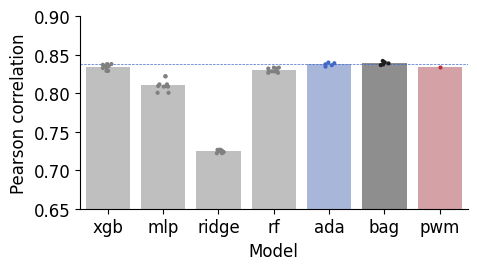

ada vs xgb t-statistic: 1.8359632325566904, p-value: 0.08933329430303505
Not significant
ada vs mlp t-statistic: 8.029076238406773, p-value: 2.149037018450629e-06
Significant
ada vs ridge t-statistic: 108.50492941247667, p-value: 1.2986909091984125e-20
Significant
ada vs rf t-statistic: 5.5580028822267655, p-value: 9.258539314585612e-05
Significant
ada vs bag t-statistic: -1.1171025094948002, p-value: 0.2963743326655972
Not significant
ada vs pwm t-statistic: 1.2993075937145862, p-value: 0.2636668564702746
Not significant


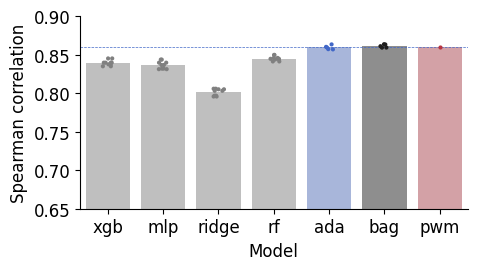

ada vs xgb t-statistic: 11.113020019139949, p-value: 5.219640335875885e-08
Significant
ada vs mlp t-statistic: 9.530820604113543, p-value: 3.133021160670298e-07
Significant
ada vs ridge t-statistic: 26.543878943799243, p-value: 1.0412294391260176e-12
Significant
ada vs rf t-statistic: 9.24250209255782, p-value: 4.4519610405210676e-07
Significant
ada vs bag t-statistic: -1.2499842477487322, p-value: 0.24663133283898453
Not significant
ada vs pwm t-statistic: -0.10256857511226757, p-value: 0.9232417064708116
Not significant


In [3]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind
# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [performances_pearson, performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=3))
    colours = ['gray' if 'ada' not in model and 'pwm' not in model and 'bag' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'ada' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'ada' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'ada' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')

    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_adaboost_comparison_{name}.png'), bbox_inches='tight', dpi=300)